#### Bayesian linear regression with Metropolis algorithm

In `09`, we have seen Bayesian linear regression at work

A few `numerical techniques` are explored

* Gradient descent to obtain `MAP or ML estimator of parameters`
* Taylor approximation and Laplace's method to approximate `posterior distribution of parameters`, so we can sample from it to get model uncertainty
* Monte Carlo integration to approximate Bayesian marginalization to obtain `prediction distribution` at testing data points (including prediction mean and variance)

One thing that took quite some effort is the Taylor approximation and Laplace's method. In this notebook, we will replace this step and avoid the derivation using the Metropolis algorithm (`notes_06`)

Put everything together, we implement Bayesian linear regression with Metropolis algorithm in Python, and see how it goes

In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

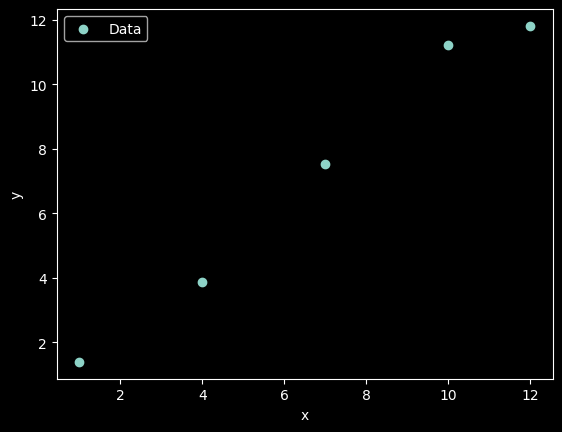

In [18]:
# Generate data
np.random.seed(42)
true_a = 1
x = np.array([1, 4, 7, 10, 12])

# True standard deviation of noise in measured y, only used in generating data
sigma_d_true = 0.8

# Guessed standard deviation of noise in measured y, only used in model
sigma_d = 1.0

# Guessed standard deviation of prior on a, only used in model
sigma_a = 1.0

y = true_a * x + np.random.normal(0, sigma_d_true, size=x.shape)

plt.scatter(x, y, label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### Gradient descent

In [19]:
learning_rate = 0.01
iterations = 10000

# Initial guess
a = 0.0

# Gradient descent to find MAP estimate
for k in range(iterations):
    y_pred = a * x
    prior_a = np.mean(a**2) / sigma_a**2 # if prior_a is uniformly distributed, this becomes 1
    likelihood = np.mean((y_pred - y)**2) / sigma_d**2
    loss = prior_a + likelihood

    grad_prior_a = 2 * np.mean(a) / sigma_a**2
    grad_likelihood = 2 * np.mean((y_pred - y) * x) / sigma_d**2
    grad_loss = grad_prior_a + grad_likelihood

    a -= learning_rate * grad_loss

    if k % (iterations//10) == 0:
        print(f"Iteration {k}: loss = {loss:.4f}, a = {a:.4f}")

a_map = a
print(f"MAP estimate of a: {a_map:.4f}")

Iteration 0: loss = 67.7990, a = 1.2941
Iteration 1000: loss = 1.3456, a = 1.0270
Iteration 2000: loss = 1.3456, a = 1.0270
Iteration 3000: loss = 1.3456, a = 1.0270
Iteration 4000: loss = 1.3456, a = 1.0270
Iteration 5000: loss = 1.3456, a = 1.0270
Iteration 6000: loss = 1.3456, a = 1.0270
Iteration 7000: loss = 1.3456, a = 1.0270
Iteration 8000: loss = 1.3456, a = 1.0270
Iteration 9000: loss = 1.3456, a = 1.0270
MAP estimate of a: 1.0270


#### Recall the steps in Metropolis

1. **Initialization**: Start with an empty sample list, start with an initial, guessed sample $x_0$
2. **Proposal**: Generate a candidate new sample $x_*$ from a `proposal distribution` $q(x_*|x_0)$
3. **Acceptance probability**: Compute `acceptance probability` of $x_*$
   $$\alpha = \min\left(1, \frac{f(x_*)}{f(x_0)}\right)$$
4. **Acceptance or rejection**: Accept $x_*$ as new sample with `probability` $\alpha$
5. **Add to list**: If $x_*$ is `accepted`, add $x_*$ to sample list, and then set $x_*$ as the new $x_0$ for next iteration; `otherwise`, add $x_0$ to sample list
6. **Iteration**: Repeat steps 2-5

In [20]:
np.random.seed(42)

sampling_methods = ['laplace', 'metropolis']
sampling = 'metropolis'

if sampling not in sampling_methods:
    raise ValueError(f"Invalid sampling method: {sampling}. Allowed methods are {sampling_methods}.")

# Sample a
num_samples = 500

if sampling == 'metropolis':
    # posterior function p(a|D)
    def posterior(a):
        prior = np.exp(-0.5 * (a**2) / sigma_a**2)
        likelihood = np.exp(-0.5 * np.sum((y - a * x)**2) / sigma_d**2)
        return prior * likelihood

    # Metropolis algorithm
    samples = []
    current_a = a_map
    current_post = posterior(current_a)
    proposal_std = 2e-1
    accepted = 0

    for _ in range(num_samples):
        proposed_a = np.random.normal(current_a, proposal_std)
        proposed_post = posterior(proposed_a)

        acceptance_prob = proposed_post / current_post
        if np.random.rand() < acceptance_prob:
            accepted += 1
            current_a = proposed_a
            current_post = proposed_post

        samples.append(current_a)

    samples = np.array(samples)
    acceptance_rate = accepted / num_samples
    print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

elif sampling == 'laplace':
    # dda2 = 1 + 1 * np.sum(x**2)
    dda2 = 1 / sigma_a**2 + 1 * np.sum(x**2) / sigma_d**2

    posterior_std_a = np.sqrt(1/dda2)
    print(f"Posterior standard deviation of a: {posterior_std_a}")

    samples = np.random.normal(a_map, posterior_std_a, num_samples)

print(f'a_samples shape: {samples.shape}')

Metropolis acceptance rate: 0.37
a_samples shape: (500,)


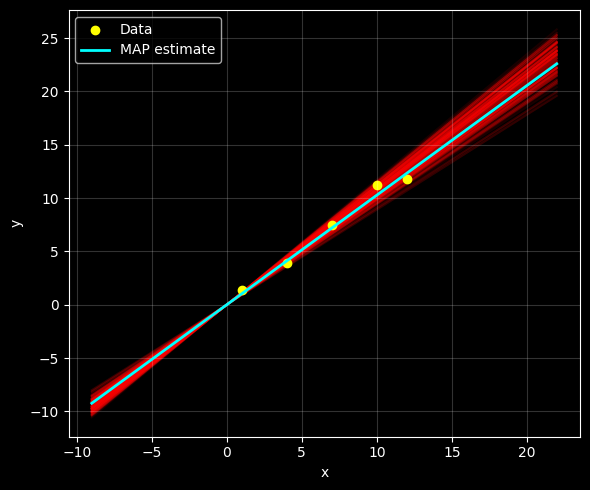

In [21]:
fig_1, ax_1 = plt.subplots(figsize=(6, 5))

ax_1.scatter(x, y, label='Data', c='yellow')
ax_1.set_xlabel('x')
ax_1.set_ylabel('y')
ax_1.grid(alpha=0.2)

# Plot some sampled lines
x_test = np.linspace(x.min()-10, x.max()+10, 200)
for i in range(200):
    a_sample = samples[i]
    y_test = a_sample * x_test
    ax_1.plot(x_test, y_test, color='r', alpha=0.1, zorder=-10)

ax_1.plot(x_test, a_map * x_test, color='cyan', label='MAP estimate', linewidth=2)

ax_1.legend()
plt.tight_layout()
plt.show()

#### `Bayesian marginalization` with Monte Carlo

In [22]:
# Generate new data points for prediction
posterior_mean_y = np.zeros(len(x_test))
posterior_std_y = np.zeros(len(x_test))

# Number of samples to draw from the predictive distribution (likelihood function at each x)
num_samples_per_predictive = 1

# For each x_test, compute the posterior predictive distribution
for i, x_ in enumerate(x_test): # for each x_...
    predictive_samples = [] # a list to collected samples sampled from likelihood functions at x_
    for a_sample in samples: # ....there will be summation of various likelihood functions corresponding to each sample of a
        # Predictive mean and variance for current a_sample, from likelihood function equation correspondin to a_sample and x_
        predictive_mean = a_sample * x_
        predictive_var = sigma_d**2
        # Use samples to represent the likelihood function
        individual_pred_dist = np.random.normal(predictive_mean, np.sqrt(predictive_var), num_samples_per_predictive)
        predictive_samples.extend(individual_pred_dist) # add samples from this likelihood function to list of collected samples

    # Compute the mean and std deviation of the predictive distribution for x_
    posterior_mean_y[i] = np.mean(predictive_samples)
    posterior_std_y[i] = np.std(predictive_samples)

#### Analytical solution

In [23]:
posterior_mean_a = a_map

A_mat = 1 / sigma_a**2 + 1 * np.sum(x**2) / sigma_d**2

analytical_mean_y = x_test * posterior_mean_a
analytical_std_y = np.sqrt((x_test**2) /A_mat + sigma_d**2)

#### Plotting

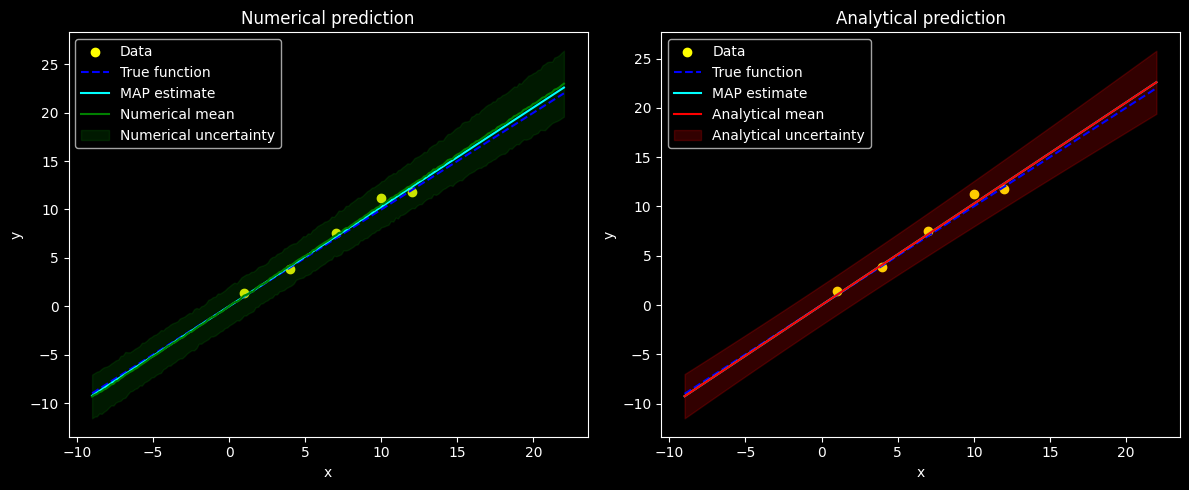

In [24]:
fig_2, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot numerical posterior mean and uncertainty
axes[0].scatter(x, y, label='Data', color='yellow')
axes[0].plot(x_test, true_a * x_test, label='True function', color='blue', linestyle='--')
axes[0].plot(x_test, a_map * x_test, label='MAP estimate', color='cyan', linestyle='-')
axes[0].plot(x_test, posterior_mean_y, label='Numerical mean', color='green')
axes[0].fill_between(x_test,
                posterior_mean_y - 2 * posterior_std_y,
                posterior_mean_y + 2 * posterior_std_y,
                color='green', alpha=0.2, label='Numerical uncertainty')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Numerical prediction')
axes[0].legend(loc='upper left')

# Plot analytical posterior mean and uncertainty
axes[1].scatter(x, y, label='Data', color='yellow')
axes[1].plot(x_test, true_a * x_test, label='True function', color='blue', linestyle='--')
axes[1].plot(x_test, a_map * x_test, label='MAP estimate', color='cyan', linestyle='-')
axes[1].plot(x_test, analytical_mean_y, label='Analytical mean', color='red')
axes[1].fill_between(x_test,
                analytical_mean_y - 2 * analytical_std_y,
                analytical_mean_y + 2 * analytical_std_y,
                color='red', alpha=0.2, label='Analytical uncertainty')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Analytical prediction')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()